In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from arch import arch_model
from sklearn.metrics import r2_score

In [2]:
gold_futures = yf.download(tickers = "GC=F",start = "2000-09-01",end ="2024-10-20",progress=False)

/Users/eloi/opt/anaconda3/envs/tidy_fiance_environment/lib/python3.10/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [3]:
gold_futures.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2
2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0
2000-09-07,274.000000,274.000000,274.000000,274.000000,274.000000,125
2000-09-08,273.299988,273.299988,273.299988,273.299988,273.299988,0


In [4]:
gold_futures.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
gold_futures = gold_futures.loc[:, ['Close']]
gold_futures.head()

,Close
Date,
2000-09-01,277.000000
2000-09-05,275.799988
2000-09-06,274.200012
2000-09-07,274.000000
2000-09-08,273.299988


In [6]:
gold_futures['returns'] = gold_futures.Close.pct_change()*100
gold_futures=gold_futures.iloc[1:]
gold_futures

,Close,returns
Date,,
2000-09-05,275.799988,-0.433217
2000-09-06,274.200012,-0.580122
2000-09-07,274.000000,-0.072944
2000-09-08,273.299988,-0.255479
2000-09-11,273.100006,-0.073173
...,...,...
2024-10-14,2647.800049,-0.368756
2024-10-15,2661.399902,0.513628
2024-10-16,2674.000000,0.473439


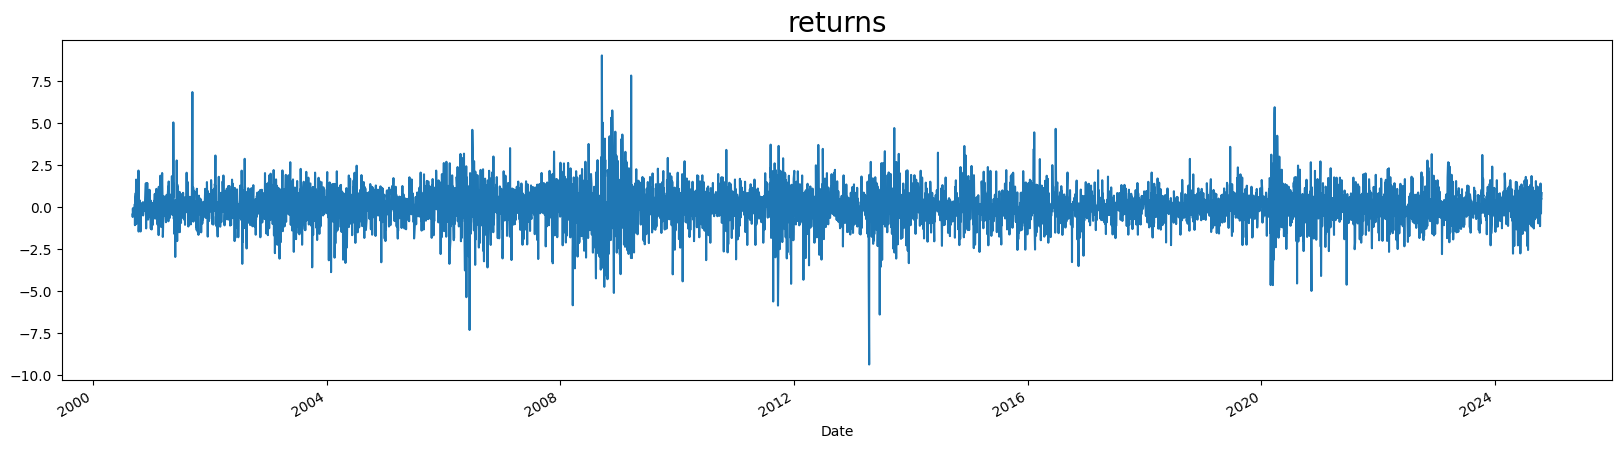

In [7]:
gold_futures.returns.plot(figsize=(20,5))
plt.title("returns",size=20)
plt.show()

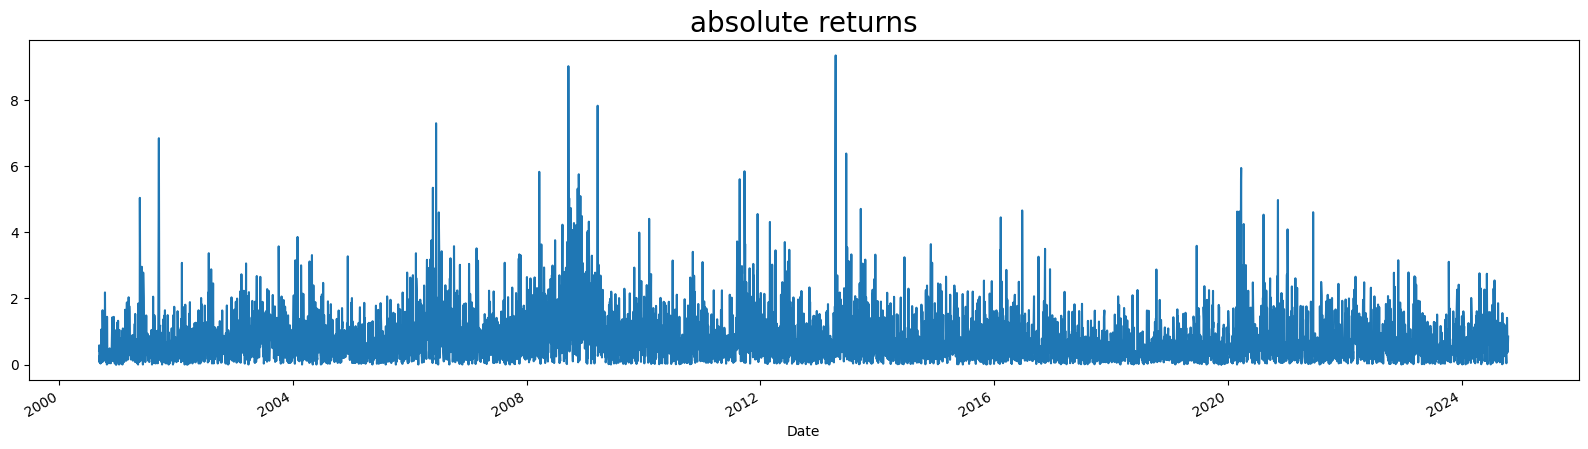

In [8]:
gold_futures.returns.abs().plot(figsize=(20,5))
plt.title("absolute returns",size=20)
plt.show()

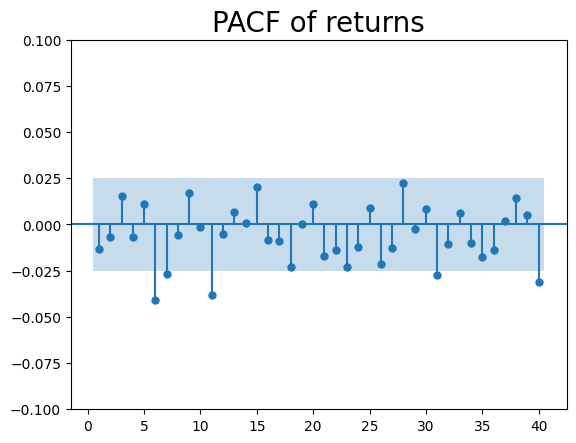

In [9]:
sgt.plot_pacf(gold_futures.returns,lags=40,alpha=0.05,zero=False,method=('ols'))
plt.title("PACF of returns",size=20)
plt.ylim(-0.1,0.1)
plt.show()

In [21]:
start_date = "2012-01-01"
end_date = "2023-01-01"

GARCH(1,1) Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4303.31
Distribution:                  Normal   AIC:                           8614.63
Method:            Maximum Likelihood   BIC:                           8638.43
                                        No. Observations:                 2836
Date:                Tue, Jan 14 2025   Df Residuals:                     2835
Time:                        00:24:19   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0662  2.034e-02      3.256 

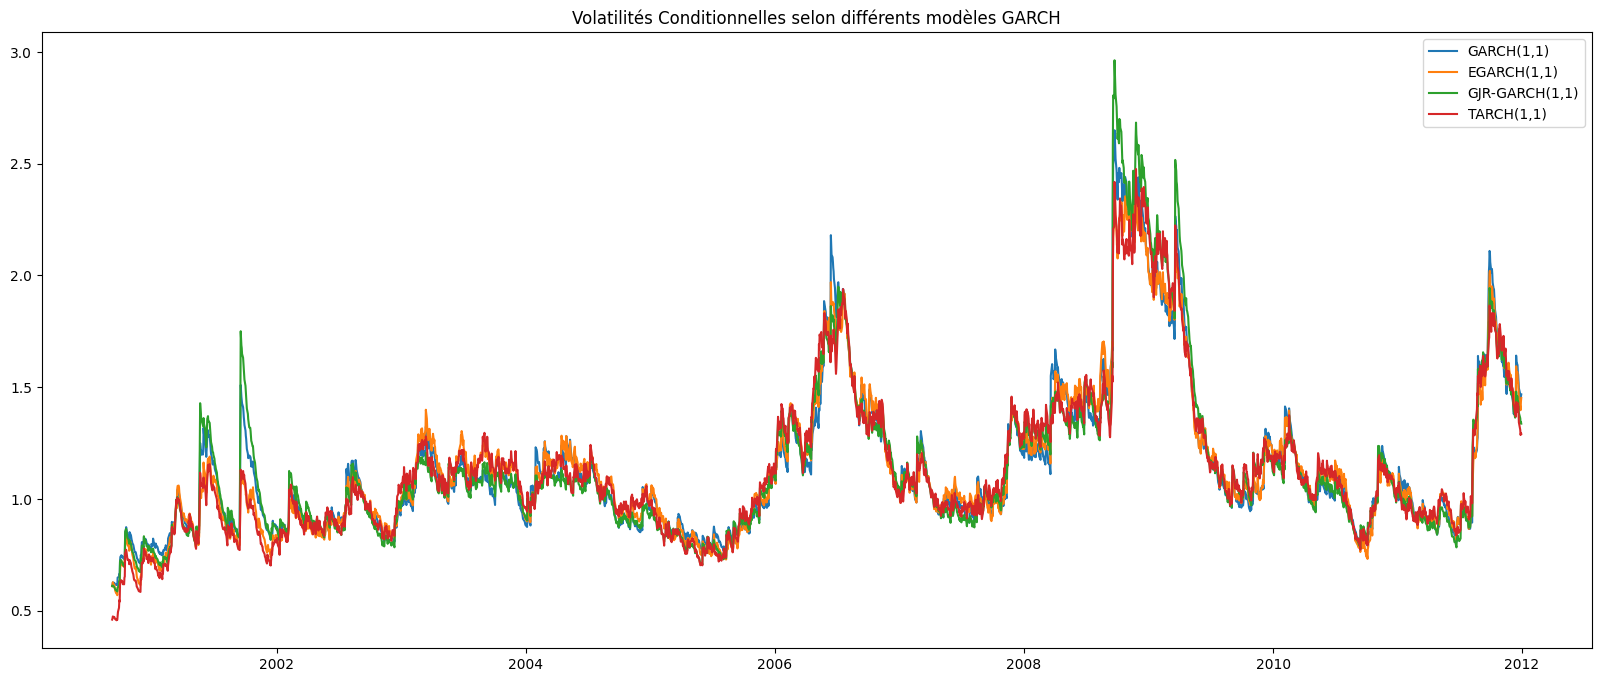

In [22]:
# 1. GARCH(1,1)
garch_model = arch_model(gold_futures.returns, vol='Garch', p=1, q=1)
garch_results = garch_model.fit(last_obs = start_date, disp="off")
print("GARCH(1,1) Summary:")
print(garch_results.summary())

# 2. EGARCH(1,1)
egarch_model = arch_model(gold_futures.returns, vol='EGarch', p=1, q=1)
egarch_results = egarch_model.fit(last_obs = start_date, disp="off")
print("\nEGARCH(1,1) Summary:")
print(egarch_results.summary())

# 3. GJR-GARCH(1,1)
gjr_garch_model = arch_model(gold_futures.returns, vol='Garch', p=1, o=1, q=1)
gjr_garch_results = gjr_garch_model.fit(last_obs = start_date, disp="off")
print("\nGJR-GARCH(1,1) Summary:")
print(gjr_garch_results.summary())

# 4. TARCH (Threshold GARCH)
tarch_model = arch_model(gold_futures.returns, vol='Garch', p=1, o=1, q=1, power=1.0) 
tarch_results = tarch_model.fit(last_obs = start_date, disp="off")
print("\nTARCH(1,1) Summary:")
print(tarch_results.summary())


plt.figure(figsize=(20, 8))
plt.plot(garch_results.conditional_volatility, label='GARCH(1,1)')
plt.plot(egarch_results.conditional_volatility, label='EGARCH(1,1)')
plt.plot(gjr_garch_results.conditional_volatility, label='GJR-GARCH(1,1)')
plt.plot(tarch_results.conditional_volatility, label='TARCH(1,1)')
plt.title("Volatilités Conditionnelles selon différents modèles GARCH")
plt.legend()
plt.show()

In [23]:
pred_garch = garch_results.forecast(horizon=1, align='target')
pred_egarch = egarch_results.forecast(horizon=1, align='target')
pred_gjr_garch = gjr_garch_results.forecast(horizon=1, align='target')
pred_tarch = tarch_results.forecast(horizon=1, align='target')

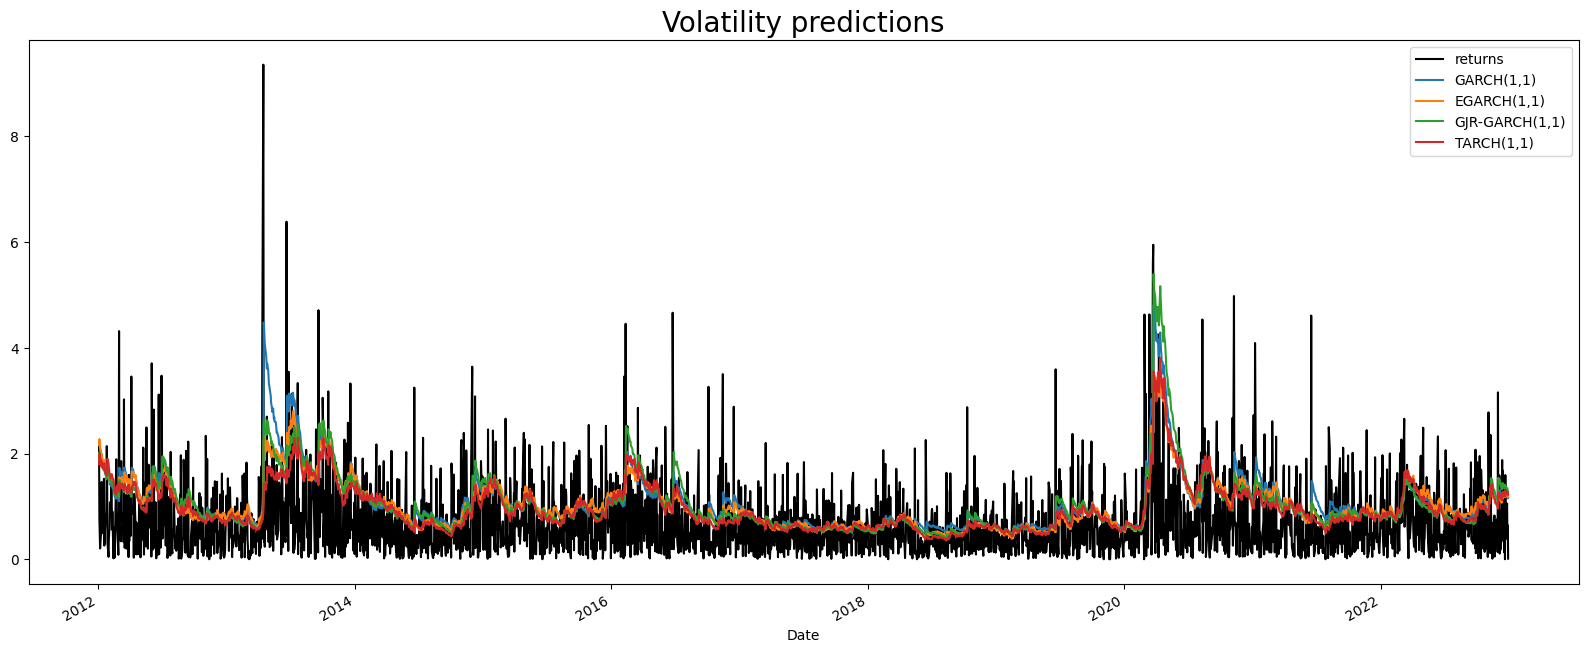

In [24]:
plt.figure(figsize=(20, 8))
gold_futures.returns[start_date:end_date].abs().plot(color ="black")
plt.plot(pred_garch.residual_variance[start_date:end_date], label='GARCH(1,1)')
plt.plot(pred_egarch.residual_variance[start_date:end_date], label='EGARCH(1,1)')
plt.plot(pred_gjr_garch.residual_variance[start_date:end_date], label='GJR-GARCH(1,1)')
plt.plot(pred_tarch.residual_variance[start_date:end_date], label='TARCH(1,1)')

plt.title("Volatility predictions",size =20)
plt.legend()
plt.show()


IGARCH(1,1) Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4303.31
Distribution:                  Normal   AIC:                           8614.63
Method:            Maximum Likelihood   BIC:                           8638.43
                                        No. Observations:                 2836
Date:                Tue, Jan 14 2025   Df Residuals:                     2835
Time:                        00:24:21   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0662  2.034e-02      3.25

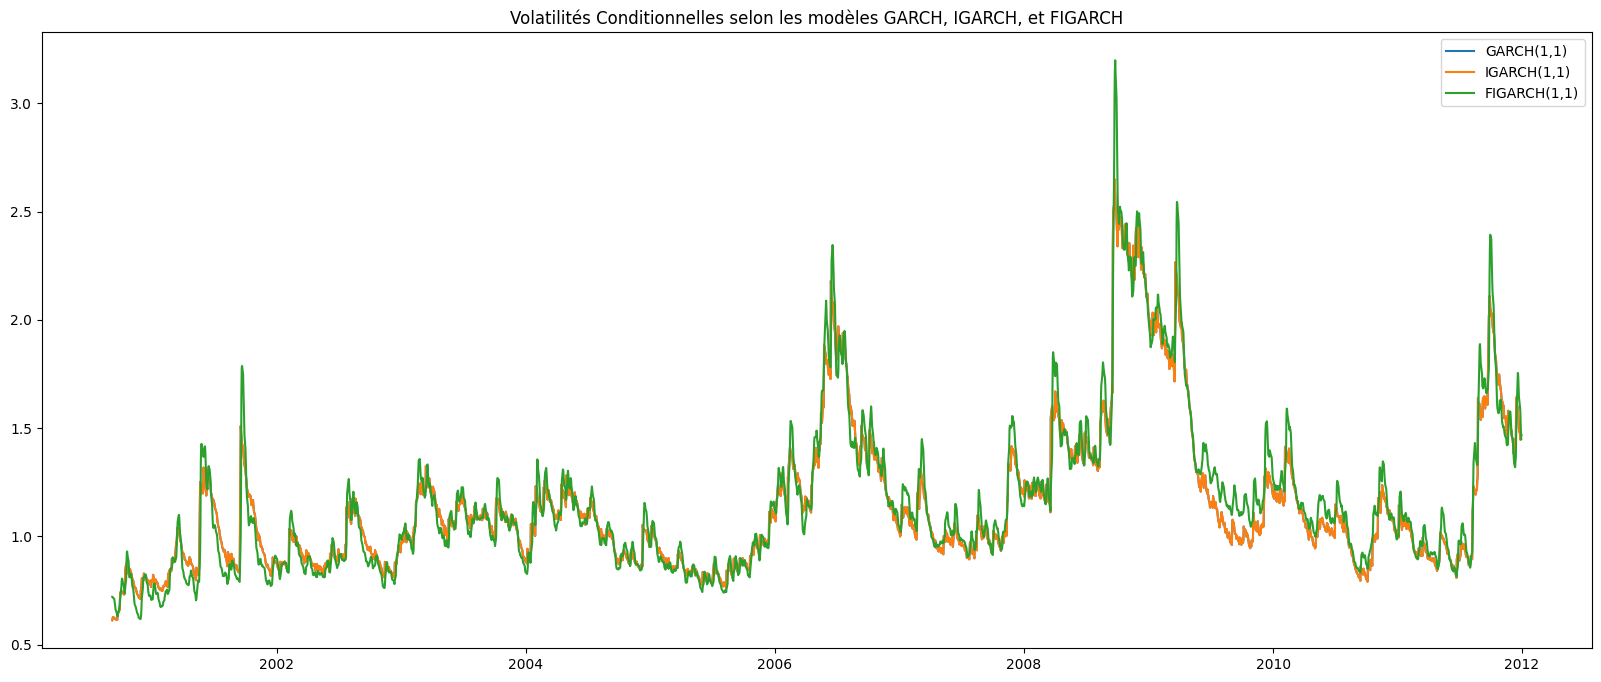

In [25]:
# 2. IGARCH(1,1) - Integrated GARCH
# IGARCH est un GARCH où la somme des paramètres alpha et beta est contrainte à 1
igarch_model = arch_model(gold_futures.returns, vol='Garch', p=1, q=1, o=0, power=2.0)
igarch_results = igarch_model.fit(last_obs = start_date, disp="off")
print("\nIGARCH(1,1) Summary:")
print(igarch_results.summary())

# 3. FIGARCH(1,1) - Fractionally Integrated GARCH
figarch_model = arch_model(gold_futures.returns, vol='FIGarch', p=1, q=1)
figarch_results = figarch_model.fit(last_obs = start_date, disp="off")
print("\nFIGARCH(1,1) Summary:")
print(figarch_results.summary())


plt.figure(figsize=(20, 8))
plt.plot(garch_results.conditional_volatility, label='GARCH(1,1)')
plt.plot(igarch_results.conditional_volatility, label='IGARCH(1,1)')
plt.plot(figarch_results.conditional_volatility, label='FIGARCH(1,1)')
plt.title("Volatilités Conditionnelles selon les modèles GARCH, IGARCH, et FIGARCH")
plt.legend()
plt.show()

In [26]:
pred_igarch = igarch_results.forecast(horizon=1, align='target')
pred_figarch = figarch_results.forecast(horizon=1, align='target')

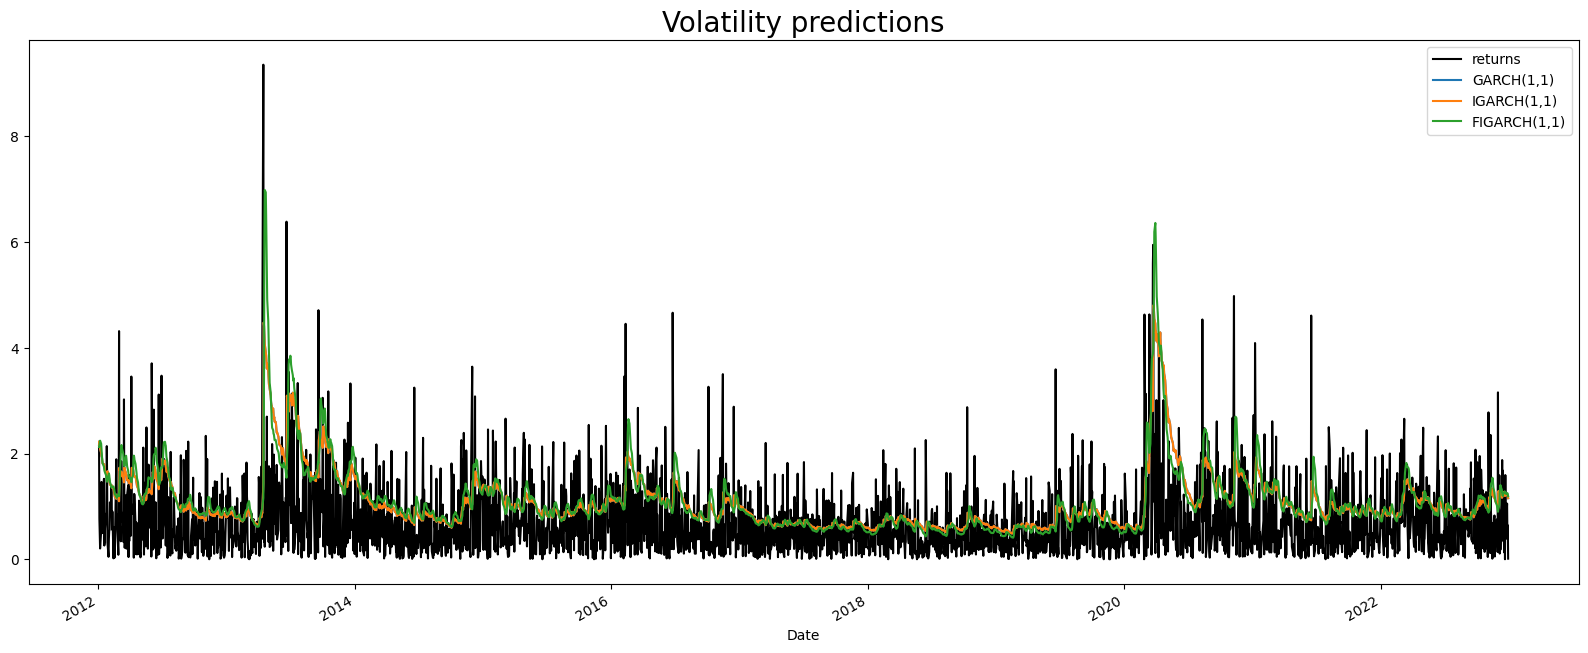

In [27]:
plt.figure(figsize=(20, 8))
gold_futures.returns[start_date:end_date].abs().plot(color ="black")
plt.plot(pred_garch.residual_variance[start_date:end_date], label='GARCH(1,1)')
plt.plot(pred_igarch.residual_variance[start_date:end_date], label='IGARCH(1,1)')
plt.plot(pred_figarch.residual_variance[start_date:end_date], label='FIGARCH(1,1)')

plt.title("Volatility predictions",size =20)
plt.legend()
plt.show()

# Loss Functions

In [28]:
L = len(gold_futures.returns[start_date:end_date])

def MAE1(ht, h_t_hat, L, T, N):
    return (1 / L) * np.sum(np.abs(h_t_hat[N:T] - ht[N:T]))

def MAE2(ht, h_t_hat, L, T, N):
    return (1 / L) * np.sum(np.abs(np.sqrt(h_t_hat[N:T]) - np.sqrt(ht[N:T])))

def MSE1(ht, h_t_hat, L, T, N):
    return (1 / L) * np.sum((h_t_hat[N:T] - ht[N:T]) ** 2)

def MSE2(ht, h_t_hat, L, T, N):
    return (1 / L) * np.sum((np.sqrt(h_t_hat[N:T]) - np.sqrt(ht[N:T])) ** 2)

def QLIKE(ht, h_t_hat, L, T, N):
    return (1 / L) * np.sum(np.log(h_t_hat[N:T]) + (ht[N:T] / h_t_hat[N:T]))

def R2LOG(ht, h_t_hat, L, T, N):
    non_zero = ht != 0.0
    ht_non_zero = ht[non_zero]
    h_t_hat_non_zero = h_t_hat[non_zero]
    L=len(ht_non_zero[N:T])
    return (1 / L) * np.sum(np.log(ht_non_zero[N:T] / h_t_hat_non_zero[N:T]) ** 2)

In [29]:
def loss_functions(ht, model_results, start_date, end_date):
    results = {
        'Model': [],
        'MSE1': [],
        'MAE1': [],
        'MSE2': [],
        'MAE2': [],
        'QLIKE': [],
        'R2LOG': []
    }
    
    # Parcourir chaque modèle dans le dictionnaire
    for model_name, df in model_results.items():
        # Obtenir les prévisions du modèle
        h_t_hat = df["h.1"]
        
        # Calculer chaque fonction de perte pour le modèle
        mse1 = MSE1(ht, h_t_hat,L, end_date, start_date)
        mae1 = MAE1(ht, h_t_hat,L, end_date, start_date)
        mse2 = MSE2(ht, h_t_hat, L,end_date, start_date)
        mae2 = MAE2(ht, h_t_hat, L,end_date, start_date)
        qlike = QLIKE(ht, h_t_hat, L,end_date, start_date)
        r2log = R2LOG(ht, h_t_hat, L,end_date, start_date)
        
        # Ajouter les résultats au dictionnaire
        results['Model'].append(model_name)
        results['MSE1'].append(mse1.round(3))
        results['MAE1'].append(mae1.round(3))
        results['MSE2'].append(mse2.round(3))
        results['MAE2'].append(mae2.round(3))
        results['QLIKE'].append(qlike.round(3))
        results['R2LOG'].append(r2log.round(3))
    
    # Convertir le dictionnaire en DataFrame
    results_df = pd.DataFrame(results)
    results_df.set_index("Model", inplace=True)
    
    return results_df

In [30]:
# Dictionnaire contenant les DataFrame des prévisions des différents modèles
model_results = {
    'GARCH': pred_garch.residual_variance,
    'EGARCH': pred_egarch.residual_variance,
    'GJR-GARCH': pred_gjr_garch.residual_variance,
    'TARCH': pred_tarch.residual_variance,
    'IGARCH': pred_igarch.residual_variance,
    'FIGARCH': pred_figarch.residual_variance
}

tableau_resultats = loss_functions(gold_futures.returns.abs(), model_results, start_date, end_date)

# Afficher le tableau final
tableau_resultats

,MSE1,MAE1,MSE2,MAE2,QLIKE,R2LOG
Model,,,,,,
GARCH,0.800,0.679,0.234,0.394,0.690,2.077
EGARCH,0.694,0.642,0.217,0.380,0.679,2.004
GJR-GARCH,0.794,0.662,0.226,0.385,0.681,2.008
TARCH,0.651,0.612,0.203,0.366,0.665,1.912
IGARCH,0.800,0.679,0.234,0.394,0.690,2.077
FIGARCH,0.906,0.699,0.246,0.400,0.698,2.104
